In [31]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# set figure size
mpl.rcParams['figure.figsize'] = (15,10)


In [ ]:
'''
load input data
'''
filename = 'data_set_170705.xlsx'
xls_file = pd.read_excel(filename, sheetname =['driver_trips',
                                               'rider_trips',
                                               'driver_data',
                                               'rider_data',
                                               'city_metrics'])

In [8]:
'''
Specify some data sets
'''

driver_trips =  xls_file['driver_trips']
rider_trips = xls_file['rider_trips']
driver_data = xls_file['driver_data']
rider_data = xls_file['rider_data']
city_metrics = xls_file['city_metrics']

rider_trips['hour'] = rider_trips.request_time.dt.hour
rider_trips['date'] = rider_trips.request_time.dt.date
rider_trips['time_slog'] = pd.to_datetime(rider_trips.date) + rider_trips['hour'].apply(lambda x: pd.Timedelta(x, 'h'))


In [42]:
'''
filter input data
'''

rider_trips_filtered = rider_trips
print(rider_trips_filtered.shape)

# filter canceled trips
rider_trips_filtered = rider_trips_filtered[rider_trips_filtered.trip_status=='completed']
print(rider_trips_filtered.shape)

#filter nan
rider_trips_filtered = rider_trips_filtered.dropna(subset=['estimated_time_to_arrival','surge_multiplier'], how='any')
print(rider_trips_filtered.shape)

#common noise : surge price = 1
trips_sp_non_active = rider_trips_filtered[ rider_trips_filtered.surge_multiplier ==1]
trips_sp_active = rider_trips_filtered[rider_trips_filtered.surge_multiplier > 1]


#filer <0 ETA
#rider_trips_filtered = rider_trips_filtered[ rider_trips_filtered.estimated_time_to_arrival >=0]
#print(rider_trips_filtered.shape)

#rush hour
FLAG_rush_hour = False

if FLAG_rush_hour:
    rush_hour_morning = ( (rider_trips_filtered.hour >=7) & (rider_trips_filtered.hour <=9) )
    rush_hour_evening =  ((rider_trips_filtered.hour >=14) & (rider_trips_filtered.hour <=18))
    rider_trips_filtered = rider_trips_filtered[ rush_hour_evening]
    print(rider_trips_filtered.shape)



(60000, 13)
(54139, 13)
(51929, 13)


All data, 	 threshold ETA: 			 9.933333333
All data, 	 threshold surge multiplier		 2.7
Surge Multiplier >1,	 threshold ETA:			 10.55
Surge Multiplier >1,	 threshold surge multiplier:	 3.3


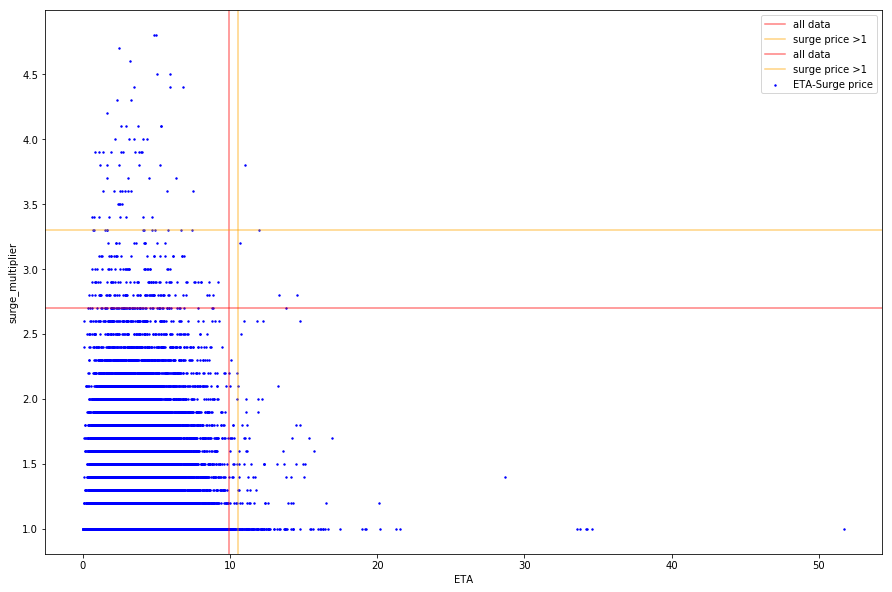

In [49]:
'''
select the outliner
'''

color_regions ={'Allen Abby':'r',
                'Blair Bend':'g',
                'Chelsea Court':'b',
                'Daisy Drive':'orange'}

threshold_ETA_perc = 0.005
threshold_sp_perc = 0.005

#all data
nb_samples = rider_trips_filtered.shape[0] 
threshold_ETA = rider_trips_filtered.sort_values('estimated_time_to_arrival',ascending = False).reset_index()\
                .estimated_time_to_arrival[np.rint(nb_samples * threshold_ETA_perc)]
threshold_sp = rider_trips_filtered.sort_values('surge_multiplier',ascending = False).reset_index()\
                .surge_multiplier[np.rint(nb_samples * threshold_sp_perc)]

#surge price >1
nb_samples = trips_sp_active.shape[0]
threshold_ETA_active = trips_sp_active.sort_values('estimated_time_to_arrival',ascending = False).reset_index()\
                .estimated_time_to_arrival[np.rint(nb_samples * threshold_ETA_perc)]
threshold_sp_active = trips_sp_active.sort_values('surge_multiplier',ascending = False).reset_index()\
                .surge_multiplier[np.rint(nb_samples * threshold_sp_perc)]

    
print('All data, \t threshold ETA: \t\t\t', threshold_ETA)
print('All data, \t threshold surge multiplier\t\t', threshold_sp)
  
print('Surge Multiplier >1,\t threshold ETA:\t\t\t', threshold_ETA_active)
print('Surge Multiplier >1,\t threshold surge multiplier:\t', threshold_sp_active)


#figure
plt.figure()
plt.scatter(x = rider_trips_filtered.estimated_time_to_arrival,
            y = rider_trips_filtered.surge_multiplier,
            s = 2, color = 'b', edgecolor = None, alpha = 1,label='ETA-Surge price')

plt.axvline(x = threshold_ETA, color = 'r', alpha = 0.5, label = 'all data')
plt.axvline(x = threshold_ETA_active, color='orange', alpha = 0.5 , label ='surge price >1')

plt.axhline(y = threshold_sp, color = 'r' , alpha = 0.5, label = 'all data')
plt.axhline(y = threshold_sp_active, color = 'orange', alpha = 0.5, label ='surge price >1')

plt.ylabel('surge_multiplier')
plt.xlabel('ETA')
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend(lines,labels, loc='best')
plt.show()
